In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("/Users/anand/Desktop/FAI/Data file/final_preprocessed_df_cleaned.csv")
df.head()

,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Target,Failure_Type_Encoded
0,1,298.1,308.6,0.315873,42.8,0,0,5
1,0,298.2,308.7,0.315873,46.3,3,0,5
2,0,298.1,308.5,0.315873,49.4,5,0,5
3,0,298.2,308.6,0.315873,39.5,7,0,5
4,0,298.2,308.7,0.315873,40.0,9,0,5


In [3]:
df.columns

Index(['Type', 'Air_temperature_K', 'Process_temperature_K',
       'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Target',
       'Failure_Type_Encoded'],
      dtype='object')

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Your DataFrame and numerical columns
numerical_columns = ['Air_temperature_K', 'Process_temperature_K', 
                     'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Save the scaled DataFrame as a pickle file
df.to_pickle("scaled.pkl")

print("Scaled DataFrame saved as 'scaled.pkl'")


Scaled DataFrame saved as 'scaled.pkl'


In [9]:
df['Failure_Type_Encoded'].value_counts()

Failure_Type_Encoded
5    9652
0     112
2      95
1      78
4      45
3      18
Name: count, dtype: int64

In [15]:
# Balancing the dataset using SMOTE 
from imblearn.combine import SMOTEENN

X = df.drop(['Target', 'Failure_Type_Encoded'], axis=1)

# Target
y = df['Failure_Type_Encoded']

# Initialize SMOTEENN to balance all classes
smt = SMOTEENN(random_state=42, sampling_strategy='not majority')  # all classes except the largest will be balanced

# Resample
X_res, y_res = smt.fit_resample(X, y)

# Check new distribution
print(y_res.value_counts())


/opt/anaconda3/envs/mlproj/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/mlproj/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/mlproj/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Failure_Type_Encoded
0    9652
3    9652
4    9652
1    9647
2    9637
5    8637
Name: count, dtype: int64


In [16]:
print(X_res.shape)
print(y_res.shape)

(56877, 6)
(56877,)


In [17]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

In [20]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(45501, 6) (11376, 6)
(45501,) (11376,)


In [21]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_clf(true, predicted, y_proba=None):
    """
    y_proba: optional predicted probabilities (n_samples, n_classes) for ROC-AUC
    """
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted, average='weighted')        # weighted average for imbalanced classes
    precision = precision_score(true, predicted, average='weighted')
    recall = recall_score(true, predicted, average='weighted')
    
    if y_proba is not None:
        roc_auc = roc_auc_score(true, y_proba, multi_class='ovr')  # one-vs-rest multiclass ROC
    else:
        roc_auc = None  # ROC-AUC cannot be computed from class labels only

    return acc, f1, precision, recall, roc_auc


In [37]:
X_res['Failure_Type_Encoded']

KeyError: 'Failure_Type_Encoded'

In [27]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [35]:
from sklearn.model_selection import train_test_split

def evaluate_models(X, y, models):
    '''
    Evaluates multiple classifiers and prints metrics.
    Handles multiclass targets and optional ROC-AUC.
    Returns a DataFrame with model names and test accuracy.
    '''
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    models_list = []
    accuracy_list = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Optional: predicted probabilities for ROC-AUC
        if hasattr(model, "predict_proba"):
            y_train_proba = model.predict_proba(X_train)
            y_test_proba = model.predict_proba(X_test)
        else:
            y_train_proba = None
            y_test_proba = None
        
        # Training metrics
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_clf(
            y_train, y_train_pred, y_proba=y_train_proba
        )
        
        # Test metrics
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_rocauc_score = evaluate_clf(
            y_test, y_test_pred, y_proba=y_test_proba
        )
        
        print(f"\n{name}")
        print("Model performance for Training set")
        print(f"- Accuracy: {model_train_accuracy:.4f}")
        print(f"- F1 score: {model_train_f1:.4f}")
        print(f"- Precision: {model_train_precision:.4f}")
        print(f"- Recall: {model_train_recall:.4f}")
        print(f"- Roc Auc Score: {model_train_rocauc_score:.4f}" if model_train_rocauc_score is not None else "- Roc Auc Score: N/A")
        
        print("\nModel performance for Test set")
        print(f"- Accuracy: {model_test_accuracy:.4f}")
        print(f"- F1 score: {model_test_f1:.4f}")
        print(f"- Precision: {model_test_precision:.4f}")
        print(f"- Recall: {model_test_recall:.4f}")
        print(f"- Roc Auc Score: {model_test_rocauc_score:.4f}" if model_test_rocauc_score is not None else "- Roc Auc Score: N/A")
        print("="*50)
        
        models_list.append(name)
        accuracy_list.append(model_test_accuracy)
    
    # Return simple report
    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
    return report


In [36]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9960
- F1 score: 0.9959
- Precision: 0.9960
- Recall: 0.9960
- Roc Auc Score: 1.0000

Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9880
- F1 score: 0.9880
- Precision: 0.9881
- Recall: 0.9880
- Roc Auc Score: 0.9925

Gradient Boosting
Model performance for Training set
- Accuracy: 0.9762
- F1 score: 0.9759
- Precision: 0.9764
- Recall: 0.9762
- Roc Auc Score: 0.9987

Model performance for Test set
- Accuracy: 0.9727
- F1 score: 0.9724
- Precision: 0.9728
- Recall: 0.9727
- Roc Auc Score: 0.9984


/opt/anaconda3/envs/mlproj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
Model performance for Training set
- Accuracy: 0.7721
- F1 score: 0.7631
- Precision: 0.7577
- Recall: 0.7721
- Roc Auc Score: 0.9482

Model performance for Test set
- Accuracy: 0.7725
- F1 score: 0.7640
- Precision: 0.7589
- Recall: 0.7725
- Roc Auc Score: 0.9491

K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9951
- F1 score: 0.9951
- Precision: 0.9952
- Recall: 0.9951
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9907
- F1 score: 0.9906
- Precision: 0.9909
- Recall: 0.9907
- Roc Auc Score: 0.9989

XGBClassifier
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 0.9999
- Recall: 0.9999
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9959
- F1 score: 0.9959
- Precision: 0.9959
- Recall: 0.9959
- Roc Auc Score: 0.9999

CatBoosting Classifier
Model performance for Training set
- Accuracy: 0.9989
- F1 score: 0.9989
- Precision: 0.9989
- Recall: 0.9989
- Roc Auc S

In [45]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.995956
5,XGBClassifier,0.995868
6,CatBoosting Classifier,0.994023
4,K-Neighbors Classifier,0.990682
1,Decision Tree,0.988045
2,Gradient Boosting,0.972662
7,Support Vector Classifier,0.947609
3,Logistic Regression,0.772504
8,AdaBoost Classifier,0.742704


In [ ]:
rf_params = {
    "max_depth": [10, 12, None, 15, 20],          # limit tree depth
    "max_features": ['sqrt', 'log2', None],       # features considered at each split
    "n_estimators": [50, 100, 200],               # number of trees
    "min_samples_split": [2, 5, 10],              # min samples to split a node
    "min_samples_leaf": [1, 2, 4],                # min samples per leaf
    "bootstrap": [True, False]                    # bootstrap sampling
}

xgboost_params = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2),
    'learning_rate': [0.01, 0.05, 0.1],           # smaller LR reduces overfitting
    'subsample': [0.6, 0.8, 1.0],                 # fraction of rows per tree
    'colsample_bytree': [0.6, 0.8, 1.0],          # fraction of features per tree
    'gamma': [0, 0.1, 0.2, 0.3],                  # min loss reduction to make a split
    'reg_alpha': [0, 0.01, 0.1],                  # L1 regularization
    'reg_lambda': [1, 1.5, 2]                      # L2 regularization
}

catboost_params = {
    'depth': [4, 6, 8, 10],                      # tree depth
    'learning_rate': [0.01, 0.05, 0.1],          # step size
    'iterations': [100, 200, 500],               # number of trees
    'l2_leaf_reg': [1, 3, 5, 7, 9],              # L2 regularization to reduce overfitting
    'border_count': [32, 50, 100],               # numeric feature binning
    'random_strength': [1, 2, 3],                # randomness in splits to reduce overfitting
    'bagging_temperature': [0, 1, 2]             # controls randomness for boosting
}


In [49]:
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ('Random Forest', RandomForestClassifier(), rf_params),
    ('CatBoost', CatBoostClassifier(verbose=0), catboost_params)
]

In [50]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=5, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=5, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max

In [51]:
model_param

{'XGBoost': {'subsample': 0.8,
  'reg_lambda': 1.5,
  'reg_alpha': 0.01,
  'min_child_weight': 1,
  'max_depth': 9,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 0.6},
 'Random Forest': {'n_estimators': 200,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': None,
  'bootstrap': False},
 'CatBoost': {'random_strength': 1,
  'learning_rate': 0.1,
  'l2_leaf_reg': 1,
  'iterations': 500,
  'depth': 8,
  'border_count': 32,
  'bagging_temperature': 2}}

In [53]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['Random Forest']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost']),
    "CatBoost Classifier": CatBoostClassifier(**model_param['CatBoost'])
}

# Evaluate tuned models
tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)


Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9975
- F1 score: 0.9975
- Precision: 0.9975
- Recall: 0.9975
- Roc Auc Score: 1.0000

XGBClassifier
Model performance for Training set
- Accuracy: 0.9960
- F1 score: 0.9960
- Precision: 0.9961
- Recall: 0.9960
- Roc Auc Score: 1.0000

Model performance for Test set
- Accuracy: 0.9901
- F1 score: 0.9900
- Precision: 0.9901
- Recall: 0.9901
- Roc Auc Score: 0.9998
0:	learn: 1.4591185	total: 15.7ms	remaining: 7.82s
1:	learn: 1.2519052	total: 26.5ms	remaining: 6.6s
2:	learn: 1.0968087	total: 36ms	remaining: 5.96s
3:	learn: 0.9793633	total: 45.4ms	remaining: 5.63s
4:	learn: 0.8873037	total: 54.9ms	remaining: 5.43s
5:	learn: 0.8085674	total: 64ms	remaining: 5.27s
6:	learn: 0.7444601	total: 73.1ms	remaining: 5.15s
7:	learn: 0.6864025	total: 82.1ms	remaining: 5.05s
8:	learn: 0.6378912	total:

In [54]:
tuned_report

,Model Name,Accuracy
0,Random Forest Classifier,0.997539
2,CatBoost Classifier,0.991913
1,XGBClassifier,0.990067


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest with tuned hyperparameters
best_model = RandomForestClassifier(**model_param['Random Forest'])

# Fit on training data
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL: Random Forest Classifier")
print("Accuracy Score: {:.4f}".format(score))
print(cr)


FINAL MODEL: Random Forest Classifier
Accuracy Score: 0.9976
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1958
           1       1.00      1.00      1.00      1878
           2       1.00      1.00      1.00      1903
           3       1.00      1.00      1.00      1920
           4       0.99      1.00      1.00      1990
           5       1.00      0.99      0.99      1727

    accuracy                           1.00     11376
   macro avg       1.00      1.00      1.00     11376
weighted avg       1.00      1.00      1.00     11376



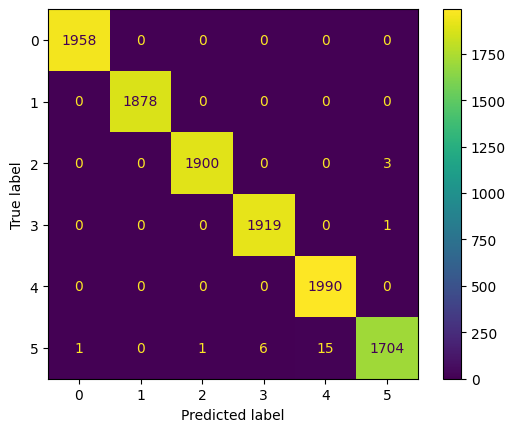

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [57]:
import joblib
joblib.dump(best_model, "random_forest_tuned.pkl", compress=3)  # compress=3–9


['random_forest_tuned.pkl']

In [ ]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier

# 1️⃣ Load the scaled dataset (just to get column order if needed)
df_scaled = joblib.load("scaled.pkl")  # Your previously scaled DataFrame
numerical_columns = ['Type','Air_temperature_K', 'Process_temperature_K', 
                     'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']

# 2️⃣ Load the trained best model
best_model = joblib.load("random_forest_tuned.pkl")  # Your Random Forest model file

# 3️⃣ Create a sample input (raw values)
sample_input = pd.DataFrame([{
    'Type' :2,
    'Air_temperature_K': 101.6,
    'Process_temperature_K': 300.5,
    'Rotational_speed_rpm':700.7,
    'Torque_Nm': 10.4,
    'Tool_wear_min': 50.2
}])

# Ensure columns are in the same order as training
sample_input = sample_input[numerical_columns]

# 4️⃣ Make prediction
predicted_class = best_model.predict(sample_input)
predicted_prob = best_model.predict_proba(sample_input)  # Probabilities for each class

# 5️⃣ Map the predicted numeric class to the failure type name
failure_mapping = {
    0: 'No Failure',
    1: 'HEAT DISSIPATION FAILURE',
    2: 'OVERSTRAIN FAILURE',
    3: 'POWER FAILURE',
    4: 'RANDOM FAILURE',
    5: 'TOOL WEAR FAILURE'
}

# 6️⃣ Handle "No Failure" using probability threshold
threshold = 0.5  # you can adjust this
max_prob = max(predicted_prob[0])
if max_prob < threshold:
    predicted_class_name = 'No Failure'
else:
    predicted_class_name = failure_mapping[predicted_class[0]]

# 7️⃣ Print results
print("Predicted Failure Type (Encoded):", predicted_class[0])
print("Predicted Failure Type (Name):", predicted_class_name)
print("Predicted Class Probabilities:", predicted_prob[0])


Predicted Failure Type (Encoded): 2
Predicted Failure Type (Name): No Failure
Predicted Class Probabilities: [0.01  0.135 0.325 0.    0.23  0.3  ]
